In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima # for determining ARIMA orders
%matplotlib inline
#ignore harmless warnings
import warnings 
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [3]:
df = pd.read_csv("../csv-files/mid-2017-2019-datetime.csv", index_col=[0], parse_dates=[0])
df.head()

FileNotFoundError: [Errno 2] File ../csv-files/mid-2017-2019-datetime.csv does not exist: '../csv-files/mid-2017-2019-datetime.csv'

In [4]:
df_gas = pd.read_csv("gas_data.csv",index_col=[0], parse_dates=[0],encoding = "ISO-8859-1")
df_gas.head()


,SAP(£/MWh),EU ETS (£/MWh),Gas (£/MWh)
Date,,,
2016-01-01,10.44,1.099207,14.848207
2016-01-02,10.29,1.099207,14.700207
2016-01-03,10.44,1.099207,14.853207
2016-01-04,11.22,1.099207,15.635207
2016-01-05,11.25,1.090321,15.654321


In [5]:
df=pd.read_csv("mid-gas-2017-2019.csv",index_col=[0], parse_dates=[0])
df.head()

,Price,Volume,Settlement Period,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,SAP,EU_ETS,Gas
datetime,,,,,,,,,,,,,,
2017-01-01 00:00:00,44.90,505.00,1,0.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832
2017-01-01 00:30:00,47.13,559.15,2,0.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832
2017-01-01 01:00:00,45.62,649.35,3,1.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832
2017-01-01 01:30:00,44.05,712.65,4,1.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832
2017-01-01 02:00:00,44.83,599.15,5,2.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832


In [6]:
df_INDO=pd.read_csv('INDO-2017-2019.csv',index_col=[0],parse_dates=[0])

df_INDO.head(3)

,Settlement_Period,INDO
datetime,,
2017-01-01 00:00:00,1,27239
2017-01-01 00:30:00,2,27814
2017-01-01 01:00:00,3,27453


In [7]:
df=pd.merge(df,df_INDO['INDO'], how='inner', left_index=True, right_index=True)
df.head()

,Price,Volume,Settlement Period,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,SAP,EU_ETS,Gas,INDO
datetime,,,,,,,,,,,,,,,
2017-01-01 00:00:00,44.90,505.00,1,0.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27239
2017-01-01 00:30:00,47.13,559.15,2,0.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27814
2017-01-01 01:00:00,45.62,649.35,3,1.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27453
2017-01-01 01:30:00,44.05,712.65,4,1.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,26312
2017-01-01 02:00:00,44.83,599.15,5,2.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,25289


In [8]:
#Splitting the data:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

def limit(data, frm, to):
    return data[(data.index>=frm)&(data.index<to)]

In [9]:
df.sort_index(inplace=True)

In [10]:
t = df.Price.copy()
t = t.drop(t.index[t.index.duplicated()])
freq_index = pd.date_range(start=t.index[0], end=t.index[-1], freq='30T')
constructed = pd.Series(index=freq_index, name='Price')
constructed.update(t)
constructed.interpolate(inplace=True)


In [10]:
#for gas series:
g = df.Gas.copy()
g = g.drop(g.index[g.index.duplicated()])
freq_index = pd.date_range(start=g.index[0], end=g.index[-1], freq='30T')
constructed_gas = pd.Series(index=freq_index, name='Gas')
constructed_gas.update(g)
constructed_gas.interpolate(inplace=True)


In [11]:
#for INDO series:
i = df.INDO.copy()
i = i.drop(i.index[i.index.duplicated()])
freq_index = pd.date_range(start=i.index[0], end=i.index[-1], freq='30T')
constructed_indo = pd.Series(index=freq_index, name='INDO')
constructed_indo.update(i)
constructed_indo.interpolate(inplace=True)

In [25]:
train = limit(constructed, '2019-01-01', '2019-06-15')
test  = limit(constructed, '2019-06-15', '2019-07-01')
test.shape, train.shape



((768,), (7920,))

In [26]:
train_=df[df.index.isin(train.index).copy()]
train_.shape


(7810, 15)

In [27]:
#Train and test for Gas Series:
train_gas = limit(constructed_gas, '2017-01-01', '2019-06-15')
test_gas  = limit(constructed_gas, '2019-06-15', '2019-07-01')
test_gas.shape




NameError: name 'constructed_gas' is not defined

In [28]:
train_indo = limit(constructed_indo, '2017-01-01', '2019-06-15')
test_indo = limit(constructed_indo, '2019-06-15', '2019-07-01')
test_indo.shape


(768,)

In [32]:
test_gas=df[df.index.isin(test.index)].copy()
test_gas[['Gas']].shape


(768, 1)

In [33]:
test_indo=df[df.index.isin(test_indo.index)].copy()
test_indo[['INDO']].shape


(768, 1)

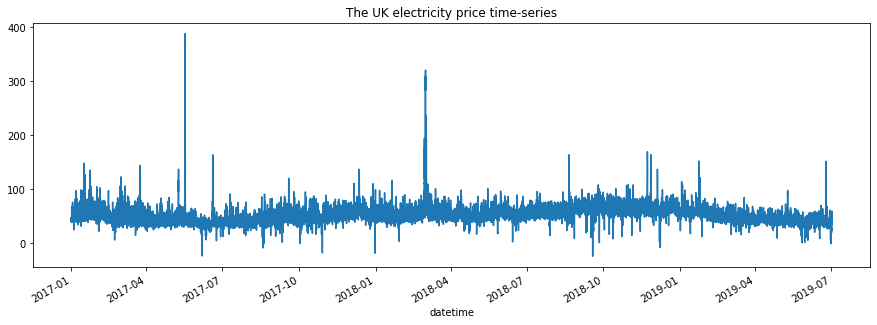

In [34]:
df['Price'].plot(figsize=(15, 5), title = 'The UK electricity price time-series')

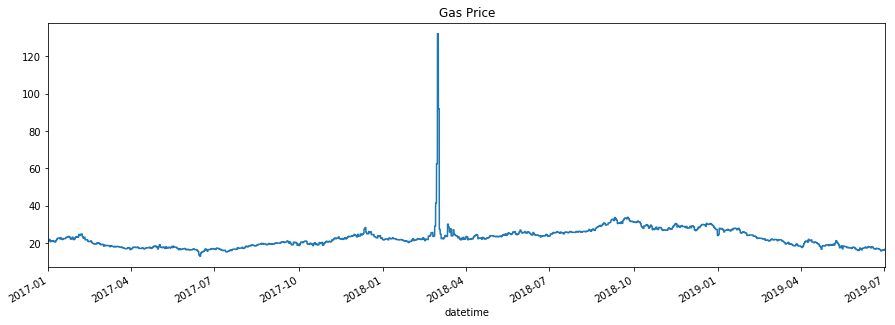

In [17]:
df['Gas'].plot(figsize=(15, 5), title = 'Gas Price')

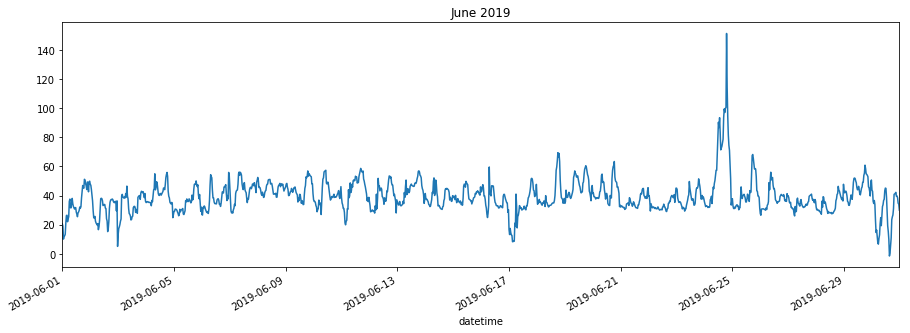

In [26]:
df['Price'].loc[(df['Price'].index >= '2019-06-01') &
               (df['Price'].index < '2019-07-01')] \
    .plot(figsize=(15, 5), title = 'June 2019')

In [27]:
#ACF and PACF
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

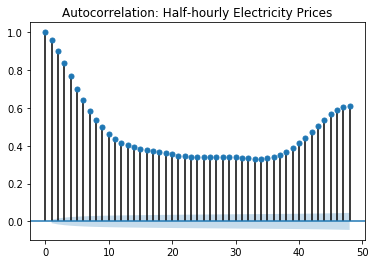

In [28]:
title = 'Autocorrelation: Half-hourly Electricity Prices'
lags = 48
plot_acf(df['Price'],title=title,lags=lags);
#This plot indicates non-stationary data, as there are a large number of lags before ACF values drop off.

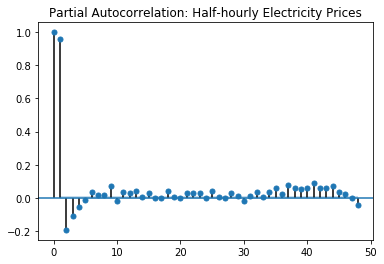

In [29]:
title='Partial Autocorrelation: Half-hourly Electricity Prices'
lags=48
plot_pacf(df['Price'],title=title,lags=lags);

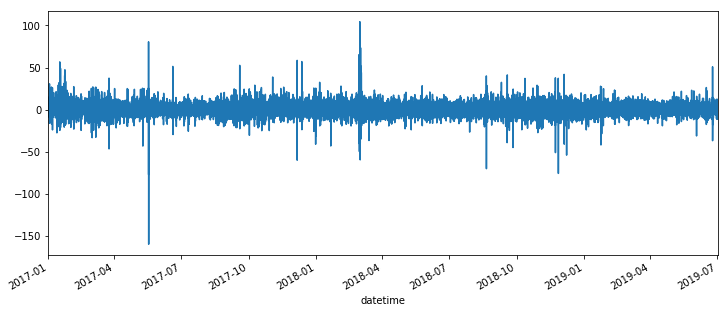

In [14]:
#First order differencing:
from statsmodels.tsa.statespace.tools import diff

df['d1'] = diff(df['Price'],k_diff=1)
df['d1'].plot(figsize=(12,5));

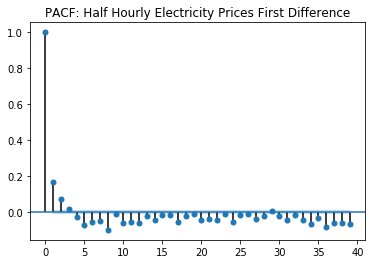

In [15]:
title='PACF: Half Hourly Electricity Prices First Difference'
lags=40
plot_pacf(df['d1'].dropna(),title=title,lags=np.arange(lags));  # be sure to add .dropna() here!

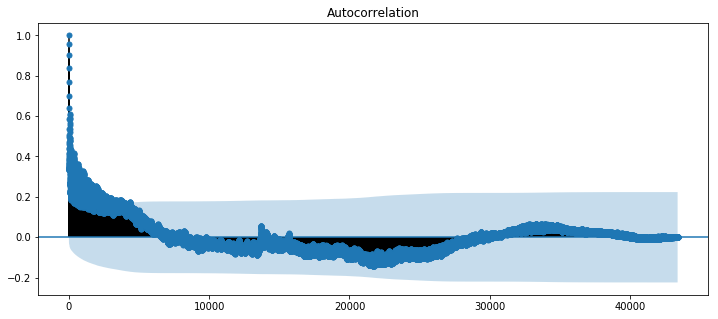

In [38]:
# full autocorrelation plot, it helps to increase the figure size using matplotlib:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,5))

plot_acf(df['Price'],ax=ax);

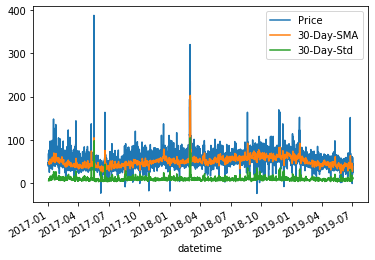

In [35]:
df['30-Day-SMA'] = df['Price'].rolling(window=48).mean()
df['30-Day-Std'] = df['Price'].rolling(window=48).std()

df[['Price','30-Day-SMA','30-Day-Std']].plot();

In [36]:
#Stationary Function
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [37]:
adf_test(df['Price'],'Stationarity test')

Augmented Dickey-Fuller Test: Stationarity test
ADF test statistic     -1.233837e+01
p-value                 6.198693e-23
# lags used             5.400000e+01
# observations          4.333600e+04
critical value (1%)    -3.430501e+00
critical value (5%)    -2.861607e+00
critical value (10%)   -2.566806e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [38]:
auto_arima(df['Price'],error_action='ignore').summary()

KeyboardInterrupt: 

In [51]:
stepwise_fit = auto_arima(df['Price'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0); AIC=255996.719, BIC=256014.075, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0); AIC=254748.737, BIC=254774.770, Fit time=0.370 seconds
Fit ARIMA: order=(0, 1, 1); AIC=254926.979, BIC=254953.013, Fit time=0.286 seconds
Fit ARIMA: order=(2, 1, 0); AIC=254508.479, BIC=254543.191, Fit time=0.694 seconds
Fit ARIMA: order=(2, 1, 1); AIC=254502.519, BIC=254545.909, Fit time=25.329 seconds
Fit ARIMA: order=(3, 1, 2); AIC=252014.740, BIC=252075.486, Fit time=44.877 seconds
Fit ARIMA: order=(2, 1, 2); AIC=252026.996, BIC=252079.064, Fit time=41.051 seconds
Fit ARIMA: order=(4, 1, 2); AIC=252244.546, BIC=252313.970, Fit time=62.696 seconds
Fit ARIMA: order=(3, 1, 1); AIC=252336.514, BIC=252388.582, Fit time=44.709 seconds
Fit ARIMA: order=(3, 1, 3); AIC=252013.151, BIC=252082.575, Fit time=61.887 seconds
Fit ARIMA: order=(2, 1, 3); AIC=252013.298, BIC=252074.044, Fit time=50.235 seconds
Fit ARIMA: order=(4, 1, 3); AIC=251980.754, BIC=252058.856, Fit time=73.426 seco

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                43390
Model:                 ARIMA(4, 1, 3)   Log Likelihood             -125981.377
Method:                       css-mle   S.D. of innovations              4.413
Date:                Tue, 17 Sep 2019   AIC                         251980.754
Time:                        09:07:53   BIC                         252058.856
Sample:                             1   HQIC                        252005.381
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.003     -0.066      0.948      -0.006       0.005
ar.L1.D.y      0.6605      0.024     27.370      0.000       0.613       0.708
ar.L2.D.y      0.8486      0.020     42.441      0.000       0.809       0.888
ar.L3.D.y     -0.5682      0.022    -26.328      0.000      -0.610      -0.526
ar.L4.D.y     -0.0462      0.008     -6.008      0.000      -0.061      -0.031
ma.L1.D.y     -0.5612      0.024    -23.561      0.000      -0.608      -0.515
ma.L2.D.y     -0.8747      0.017    -50.572      0.000      -0.909      -0.841
ma.L3.D.y      0.4501      0.022     20.926      0.000       0.408       0.492
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1037           -0.0000j            1.1037           -0.5000
AR.2            1.1857           -0.1997j            1.2024           -0.0266
AR.3            1.1857           +0.1997j            1.2024            0.0266
AR.4          -13.5740           -0.0000j           13.5740           -0.5000
MA.1           -1.0865           +0.0000j            1.0865            0.5000
MA.2            1.0149           +0.0000j            1.0149            0.0000
MA.3            2.0150           +0.0000j            2.0150            0.0000
-----------------------------------------------------------------------------
"""

In [60]:
#ARMA Model:
model = ARMA(train,order=(5,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                42960
Model:                     ARMA(5, 1)   Log Likelihood             -123978.344
Method:                       css-mle   S.D. of innovations              4.336
Date:                Tue, 17 Sep 2019   AIC                         247972.688
Time:                        09:57:46   BIC                         248042.032
Sample:                    01-01-2017   HQIC                        247994.564
                         - 06-14-2019                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          49.9144      1.476     33.819      0.000      47.022      52.807
ar.L1.Price     2.0995      0.003    656.990      0.000       2.093       2.106
ar.L2.Price    -1.1770      0.007   -174.507      0.000      -1.190      -1.164
ar.L3.Price     0.0349      0.010      3.583      0.000       0.016       0.054
ar.L4.Price    -0.0357      0.011     -3.319      0.001      -0.057      -0.015
ar.L5.Price     0.0782      0.005     16.195      0.000       0.069       0.088
ma.L1.Price    -0.9845      0.002   -648.085      0.000      -0.988      -0.982
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0022           -0.0000j            1.0022           -0.0000
AR.2            1.3009           -0.1271j            1.3071           -0.0155
AR.3            1.3009           +0.1271j            1.3071            0.0155
AR.4           -1.5734           -2.2353j            2.7335           -0.3476
AR.5           -1.5734           +2.2353j            2.7335            0.3476
MA.1            1.0157           +0.0000j            1.0157            0.0000
-----------------------------------------------------------------------------
"""

In [39]:
start=len(train)
end=len(train)+len(test)-1
start
predictions = results.predict(start=start, end=end).rename('ARMA(5,1) Predictions')

NameError: name 'results' is not defined

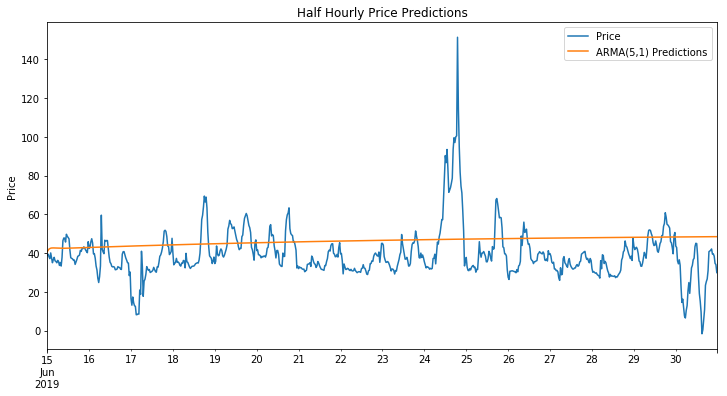

In [63]:
title = 'Half Hourly Price Predictions'
ylabel='Price'
xlabel=''

ax = test.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [64]:
#Model Evaluation
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.metrics import mean_absolute_error

error1 = mse(test, predictions)
error2 = rmse(test, predictions)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'MAE Error: {mean_absolute_error(test, predictions)}'), 
print(f'MAPE Error: {mean_absolute_percentage_error(test, predictions)}')
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print()


MAE Error: 11.443707007240512
MAPE Error: 53.924235079098594
MSE Error : 216.6732767
RMSE Error: 14.71982598



In [69]:
#ARIMA MODELS
model =ARIMA(train,order=(4,1,3))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                42959
Model:                 ARIMA(4, 1, 3)   Log Likelihood             -123958.583
Method:                       css-mle   S.D. of innovations              4.334
Date:                Tue, 17 Sep 2019   AIC                         247935.167
Time:                        10:51:02   BIC                         248013.179
Sample:                    01-01-2017   HQIC                        247959.777
                         - 06-14-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0001      0.003     -0.036      0.971      -0.006       0.006
ar.L1.D.Price     0.6487      0.025     25.583      0.000       0.599       0.698
ar.L2.D.Price     0.8460      0.021     40.687      0.000       0.805       0.887
ar.L3.D.Price    -0.5548      0.023    -24.566      0.000      -0.599      -0.511
ar.L4.D.Price    -0.0452      0.008     -5.626      0.000      -0.061      -0.029
ma.L1.D.Price    -0.5348      0.025    -21.340      0.000      -0.584      -0.486
ma.L2.D.Price    -0.8735      0.018    -49.032      0.000      -0.908      -0.839
ma.L3.D.Price     0.4233      0.022     18.823      0.000       0.379       0.467
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1059           -0.0000j            1.1059           -0.5000
AR.2            1.1993           -0.1903j            1.2143           -0.0250
AR.3            1.1993           +0.1903j            1.2143            0.0250
AR.4          -13.5691           -0.0000j           13.5691           -0.5000
MA.1           -1.0890           +0.0000j            1.0890            0.5000
MA.2            1.0149           +0.0000j            1.0149            0.0000
MA.3            2.1376           +0.0000j            2.1376            0.0000
-----------------------------------------------------------------------------
"""

In [70]:
start=len(train)
end=len(train)+len(test)-1
predictions_arima = results.predict(start=start, end=end).rename('ARIMA(2,1,1) Predictions')

In [71]:
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.metrics import mean_absolute_error

error1 = mse(test, predictions_arima)
error2 = rmse(test, predictions_arima)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'MAE Error: {mean_absolute_error(test, predictions_arima)}'), 
print(f'MAPE Error: {mean_absolute_percentage_error(test, predictions_arima)}')
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print()

MAE Error: 39.356451321146764
MAPE Error: 99.9966642704758
MSE Error : 1715.572952
RMSE Error: 41.41947551



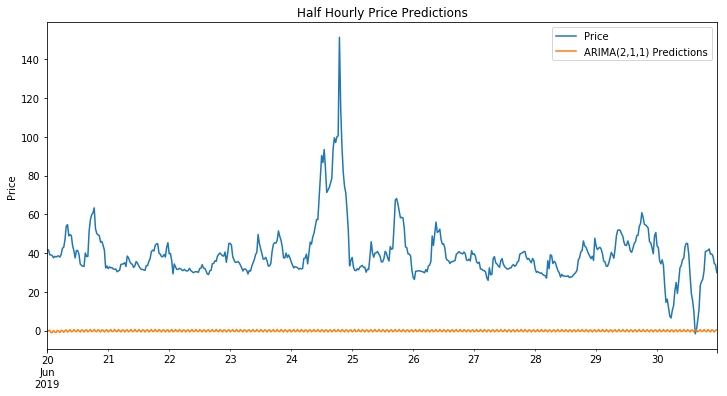

In [31]:
title = 'Half Hourly Price Predictions'
ylabel='Price'
xlabel='' 

ax = test.plot(legend=True,figsize=(12,6),title=title)
predictions_arima.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

[Text(0, 0.5, 'Prices'), Text(0.5, 0, '')]

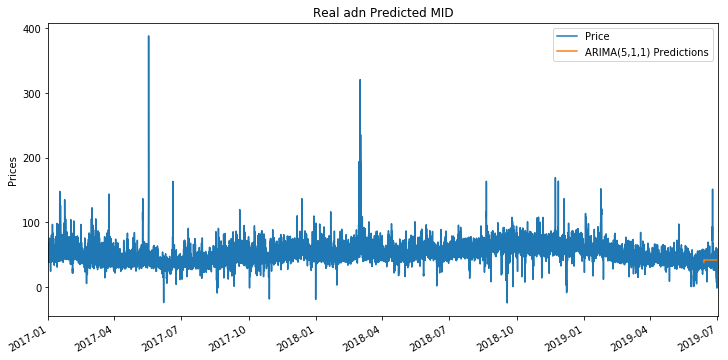

In [51]:
# Plot predictions against known values
title = 'Real adn Predicted MID'
ylabel='Prices'
xlabel='' 
ax = df['Price'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
#ax.yaxis.set_major_formatter(formatter);

In [45]:
model = SARIMAX(train,order=(5,1,1),seasonal_order=(1,0,1,12),
                exog=train_gas,
               enforce_stationarity=False,
               enforce_invertibility=False
               )
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Price   No. Observations:                42960
Model:             SARIMAX(5, 1, 1)x(1, 0, 1, 12)   Log Likelihood             -123319.055
Date:                            Tue, 17 Sep 2019   AIC                         246658.111
Time:                                    13:49:52   BIC                         246744.787
Sample:                                01-01-2017   HQIC                        246685.455
                                     - 06-14-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Gas            0.1802      0.011     17.021      0.000       0.159       0.201
ar.L1          1.0821      0.002    624.588      0.000       1.079       1.085
ar.L2         -0.0468      0.003    -16.398      0.000      -0.052      -0.041
ar.L3         -0.0527      0.003    -15.114      0.000      -0.060      -0.046
ar.L4         -0.0386      0.003    -11.400      0.000      -0.045      -0.032
ar.L5         -0.0417      0.002    -24.308      0.000      -0.045      -0.038
ma.L1         -0.9899      0.000  -2842.723      0.000      -0.991      -0.989
ar.S.L12       0.9944      0.001   1578.356      0.000       0.993       0.996
ma.S.L12      -0.9780      0.001   -742.490      0.000      -0.981      -0.975
sigma2        17.9883      0.030    599.201      0.000      17.929      18.047
===================================================================================
Ljung-Box (Q):                     1605.23   Jarque-Bera (JB):           4365050.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        52.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
train.shape

(42960,)

In [46]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast=test_gas[['Gas']]
predictions_sarima = results.predict(start=start, end=end,exog=exog_forecast, dynamic=False, typ='levels').rename('SARIMAX(5,1,1)(1,0,1,48) Predictions')
#predictions_sarima = results.predict(start=start, end=end,  
 #                                    dynamic=False,
  #                                   typ='levels').rename('SARIMAX(5,1,1)(1,0,1,12) Predictions')

In [20]:
predictions_sarima.shape


(768,)

In [47]:
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.metrics import mean_absolute_error

error1 = mse(test, predictions_sarima)
error2 = rmse(test, predictions_sarima)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'MAE Error: {mean_absolute_error(test, predictions_sarima)}'), 
print(f'MAPE Error: {mean_absolute_percentage_error(test, predictions_sarima)}')
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print()

MAE Error: 9.146337469156416
MAPE Error: 43.68716806764563
MSE Error : 174.7025661
RMSE Error: 13.21750983



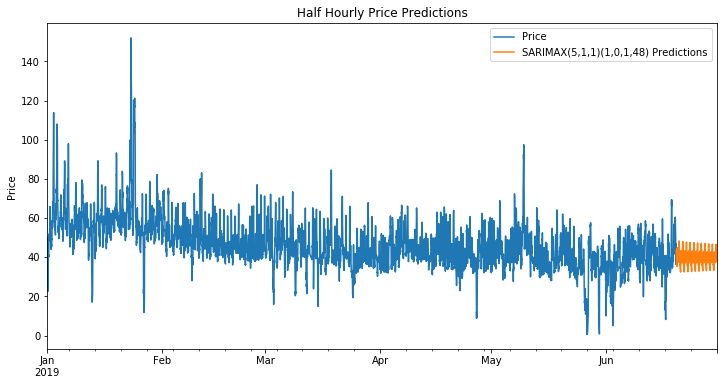

In [43]:
title = 'Half Hourly Price Predictions'
ylabel='Price'
xlabel='' 

ax = train.plot(legend=True,figsize=(12,6),title=title)
predictions_sarima.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

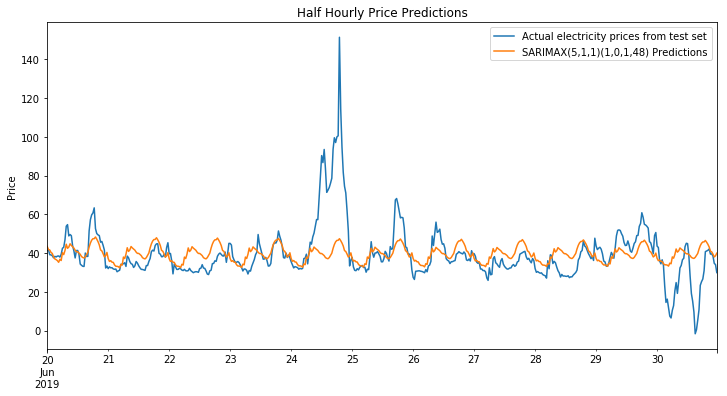

In [44]:
title = 'Half Hourly Price Predictions'
ylabel='Price'
xlabel='' 
ax = test.rename('Actual electricity prices from test set').plot(legend=True,figsize=(12,6),title=title)
predictions_sarima.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [41]:
#SARIMA with INDO:
model = SARIMAX(train.index,order=(5,1,1),seasonal_order=(1,0,1,48),
                exog=train_indo,
               enforce_stationarity=False,
               enforce_invertibility=False
               )
results = model.fit()
results.summary()

ValueError: endog and exog matrices are different sizes

In [18]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast=test_indo[['INDO']]
predictions_sarima = results.predict(start=start, end=end,exog=exog_forecast, dynamic=False, typ='levels').rename('SARIMAX(5,1,1)(1,0,1,48) Predictions')

In [20]:
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.metrics import mean_absolute_error

error1 = mse(test, predictions_sarima)
error2 = rmse(test, predictions_sarima)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'MAE Error: {mean_absolute_error(test, predictions_sarima)}'), 
print(f'MAPE Error: {mean_absolute_percentage_error(test, predictions_sarima)}')
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print()

MAE Error: 11.318902501040087
MAPE Error: 56.72133948763916
MSE Error : 208.5102642
RMSE Error:  14.4398845



In [23]:
title = 'Half Hourly Price Predictions'
ylabel='Price'
xlabel='' 

ax = train.plot(legend=True,figsize=(12,6),title=title)
predictions_sarima.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

NameError: name 'predictions_sarima' is not defined

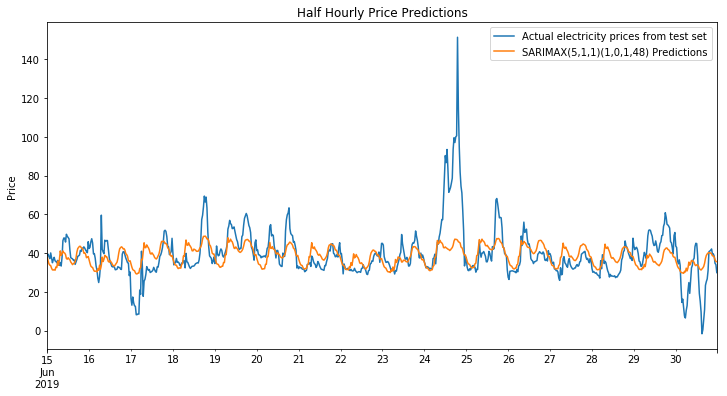

In [31]:
title = 'Half Hourly Price Predictions'
ylabel='Price'
xlabel='' 
ax = test.rename('Actual electricity prices from test set').plot(legend=True,figsize=(12,6),title=title)
predictions_sarima.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);